In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import savemat
import scipy.signal

import torch
import torchvision
import torchvision.transforms as transforms

import os

# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

import pathlib
from pathlib import Path
from imgaug import augmenters as iaa


%matplotlib notebook
%matplotlib notebook
%matplotlib inline
# %matplotlib qt

In [3]:
PATH_absolute = pathlib.Path('.').absolute()
PATH_absolute.parents[0]

sys.path.append(f'{PATH_absolute.parents[0]}')

In [4]:
%load_ext autoreload
%autoreload 2
from ROIClassifier import augmentation, cv, loading

In [264]:
# dir_name = '/Users/josh/Documents/Harvard/label_data'
# path_list = list([
#     Path(f'{dir_name}/mouse 6_28 _ day 20200903'),
#     Path(f'{dir_name}/mouse6_28 _ day20200815'),
#     Path(f'{dir_name}/mouseUnknownAi148__20210325'),
# #     Path(f'{dir_name}/mouse2_6__20210409'),
# ])



# images = loading.load_stat_and_make_spatialFootprints(path_list, stat_fileName='stat.npy', preCrop_length=241, crop_length=36, plot_pref=True)
# labels = loading.load_labels(path_list, images, label_fileName='label', fileName_is_prefix=True, plot_pref=True)

# train_x, val_x, train_y, val_y, train_idx, val_idx,    train_x_all, val_x_all, train_y_all, val_y_all = cv.cv_split_datasets(images,
#                                                                                                                           labels,
#                                                                                                                           test_fraction=0.15,
#                                                                                                                           rand_seed=None)



In [215]:
!pwd

/Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp


In [276]:
import sys
sys.path.append(r'/Users/josh/Documents/Harvard')

%load_ext autoreload
%autoreload 2
from GCaMP_ROI_classifier.old_stuff import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


concatenated images shape: (19506, 36, 36)


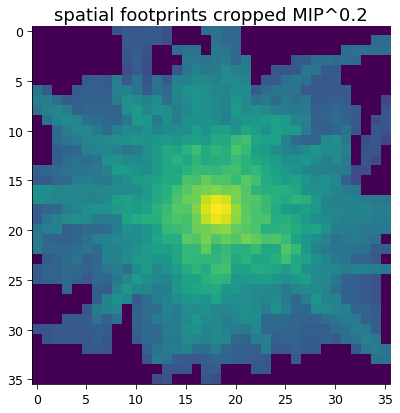

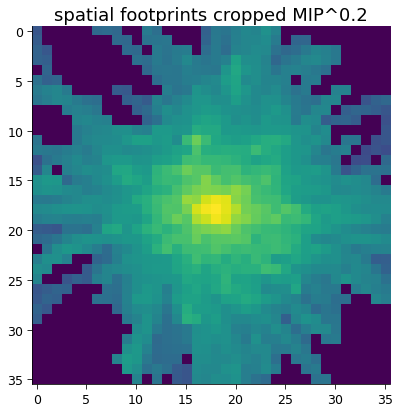

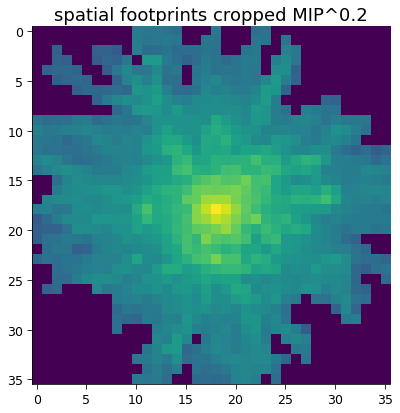

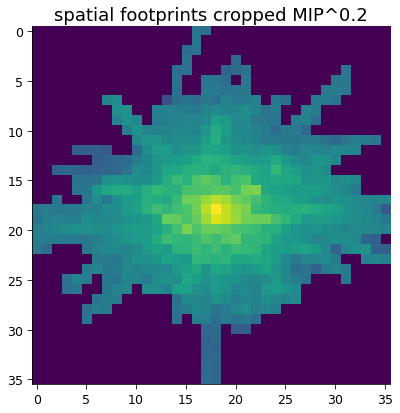

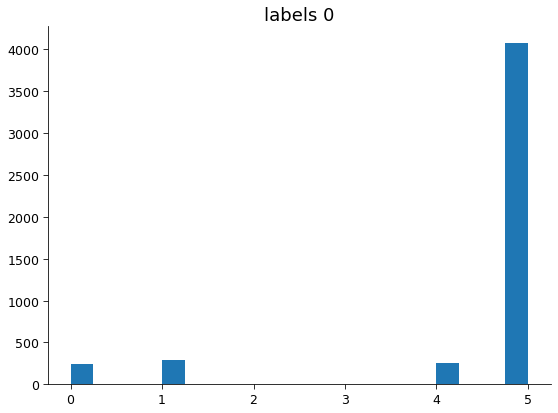

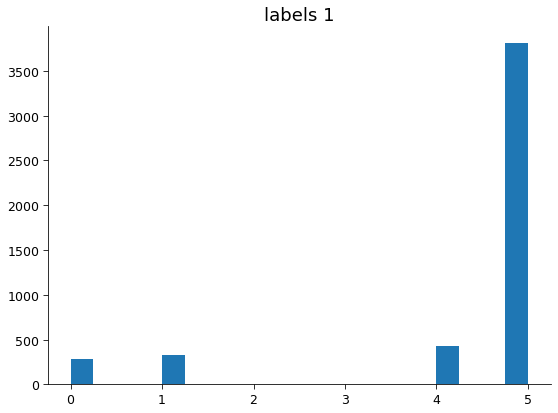

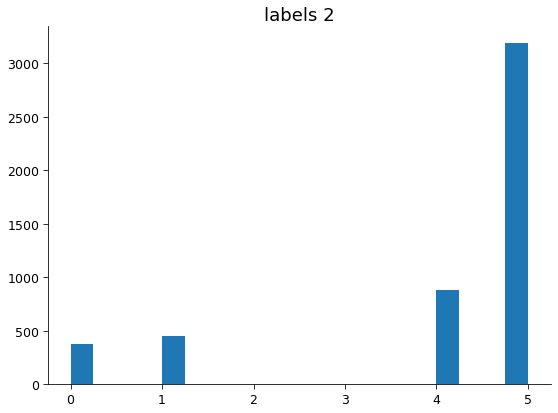

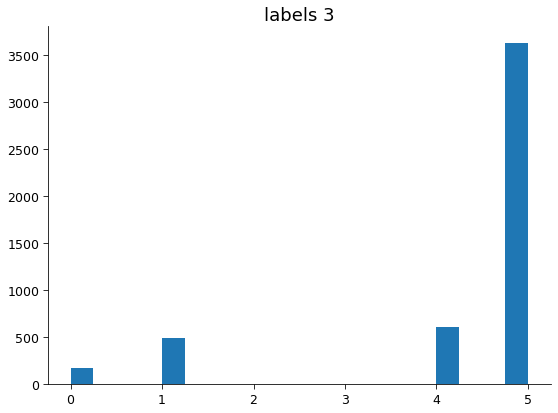

In [279]:
dir_folders = r'/Users/josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/',
             r'mouse2_6__20210409/',
             r'mouseUnknownAi148__20210325/',
          ]
fileNames_statFiles = [r'stat.npy']*len(folders)

paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images = np.concatenate(sf_all, axis=0)
print(f'concatenated images shape: {images.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
                        'labels_posthoc_all.npy',
                        'labels_posthoc_mouse2_6__20210409.npy',
                        'labels_posthoc_mouseUnknownAi148__20210325.npy'
                       ]
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

In [280]:
image_size = images.shape[-2:]
image_size

(36, 36)

In [281]:
# torch.cuda.current_device()

In [282]:
# torch.cuda.get_device_name(0)

In [283]:
dup_num = 1

Load and preprocess stat file and labels  
Labels must be made in the 'ROI_labeling_and_augmentation' script and the relabeling script  
## outputs: 'images' and 'labels' (both input into CNN)


In [284]:
def load_npy(base_dir='label_data', subpath='mouse 6_28 _ day 20200903', lbl=''):
    
    # dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
    fileName_load = 'stat.npy'

    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    # PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    stat = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
    print('stat file loaded')
    print('')

    num_ROI = stat.shape[0]
    print(f'Number of ROIs: {num_ROI}')

    height = 512
    width = 1024
    spatial_footprints_centered = np.zeros((num_ROI, 241,241))
    for i in range(num_ROI):
        spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
    spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

    # %matplotlib inline
    plt.figure()
    plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
    plt.title(f'spatial_footprints_centered_crop{lbl} MIP^0.2');

    images = spatial_footprints_centered_crop
    return spatial_footprints_centered_crop

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/stat.npy

stat file loaded

Number of ROIs: 4868


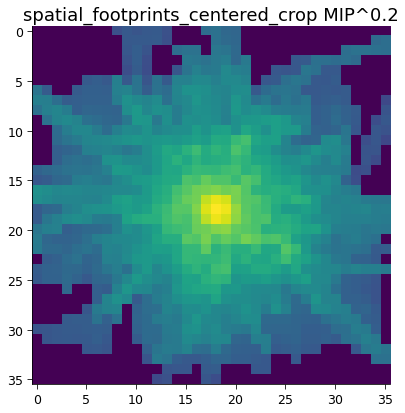

In [285]:
# LOAD stat.npy file 1
#___________________


spatial_footprints_centered_crop = load_npy(base_dir='../../label_data', subpath='mouse 6_28 _ day 20200903')
images = spatial_footprints_centered_crop


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/stat.npy

stat file loaded

Number of ROIs: 4847


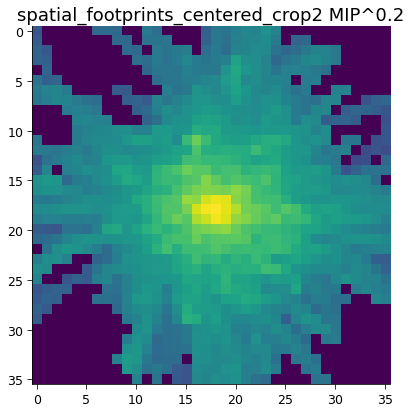

In [286]:
# # LOAD stat.npy file 2
# #___________________


spatial_footprints_centered_crop2 = load_npy(base_dir='../../label_data',
                                             subpath='mouse6_28 _ day20200815',
                                             lbl='2'
                                            )
images2 = spatial_footprints_centered_crop2


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/stat.npy

stat file loaded

Number of ROIs: 4893


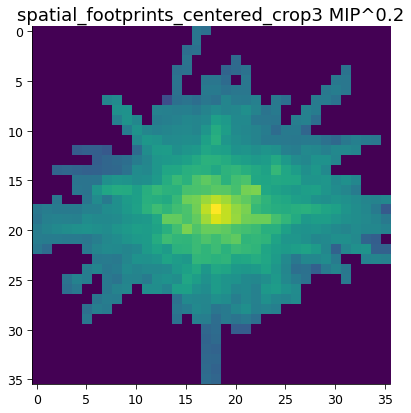

In [287]:
spatial_footprints_centered_crop3 = load_npy(base_dir='../../label_data',
                                             subpath='mouseUnknownAi148__20210325',
                                             lbl='3')
images3 = spatial_footprints_centered_crop3


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/stat.npy

stat file loaded

Number of ROIs: 4898


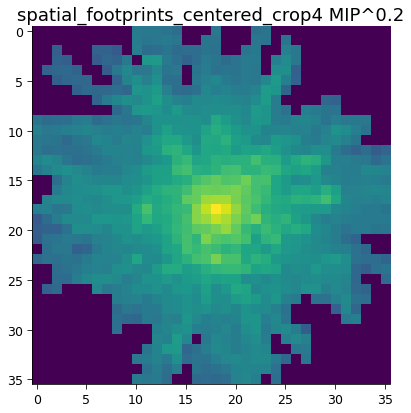

In [288]:
spatial_footprints_centered_crop4 = load_npy(base_dir='../../label_data',
                                             subpath='mouse2_6__20210409',
                                             lbl='4')
images4 = spatial_footprints_centered_crop4


In [289]:
images1 = spatial_footprints_centered_crop
images2 = spatial_footprints_centered_crop2


In [290]:
def load_labels(base_dir='../../label_data',
                 subpath='mouse 6_28 _ day 20200903',
                 fileName_load='labels_posthoc_filledIn_allCells.npy',
                 num_labels=6):
    
    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
    print('labels file loaded')
    print('')


    plt.figure()
    # plt.hist(labels,20);
    plt.hist(labels1,20);


    #check in number of labels matches number of images
    if images.shape[0] == len(labels1):
        print('number of labels and images match')
    else:
        print('WARNING: number of labels and images DO NOT match')
    
    return labels1

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/labels_posthoc_filledIn_allCells.npy

labels file loaded

number of labels and images match


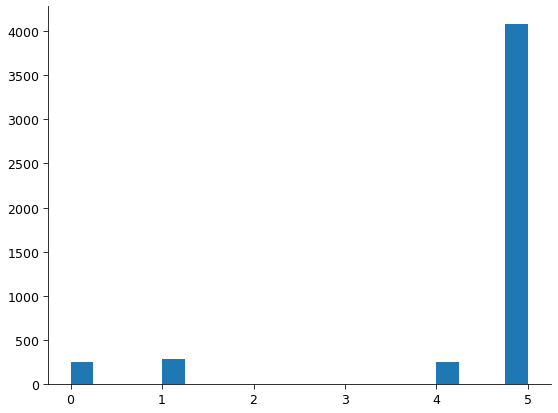

In [291]:
# # LOAD labels file 1
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
# fileName_load = 'labels_posthoc_filledIn_allCells.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels1,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels1):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')


labels1 = load_labels(base_dir='../../label_data',
            subpath='mouse 6_28 _ day 20200903',
            fileName_load='labels_posthoc_filledIn_allCells.npy',
            num_labels=6)

In [292]:
images.shape, labels1.shape

((4868, 36, 36), (4868,))

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/labels_posthoc_all.npy

labels file loaded



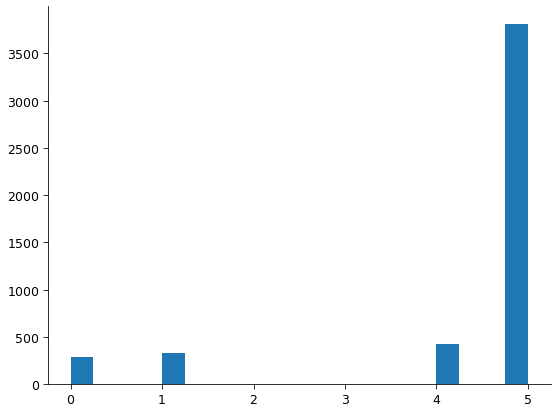

In [293]:
# # LOAD labels file 2
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
# fileName_load = 'labels_posthoc_all.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels2,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels2):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')
    
    
    
labels2 = load_labels(base_dir='../../label_data',
            subpath='mouse6_28 _ day20200815',
            fileName_load='labels_posthoc_all.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/labels_posthoc_mouseUnknownAi148__20210325.npy

labels file loaded



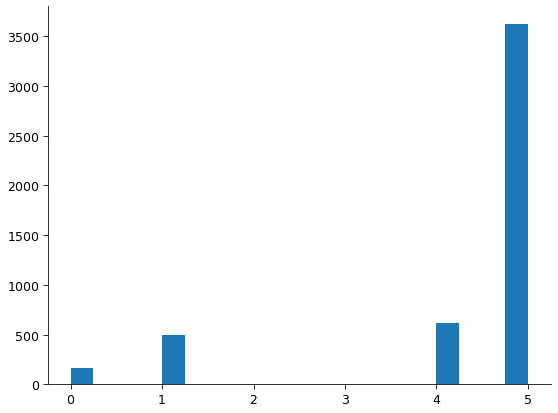

In [294]:
labels3 = load_labels(base_dir='../../label_data',
            subpath='mouseUnknownAi148__20210325',
            fileName_load='labels_posthoc_mouseUnknownAi148__20210325.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/labels_posthoc_mouse2_6__20210409.npy

labels file loaded



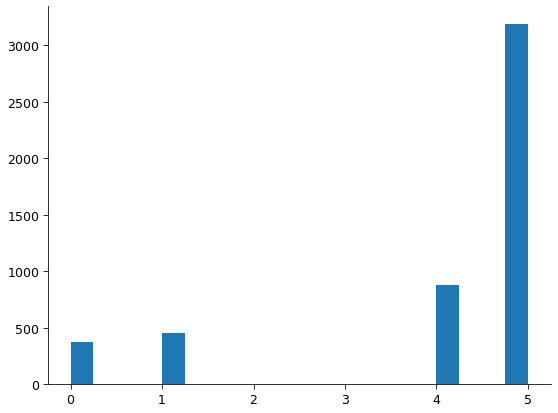

In [295]:
labels4 = load_labels(base_dir='../../label_data',
            subpath='mouse2_6__20210409',
            fileName_load='labels_posthoc_mouse2_6__20210409.npy',
            num_labels=6)

In [296]:
seed = 465
np.random.seed(seed)


# create validation set
train_x_i1, val_x_i1, train_y_i1, val_y_i1 = train_test_split(images1[:], labels1[:], test_size = 0.15)
train_x_i2, val_x_i2, train_y_i2, val_y_i2 = train_test_split(images2[:], labels2[:], test_size = 0.15)
train_x_i3, val_x_i3, train_y_i3, val_y_i3 = train_test_split(images3[:], labels3[:], test_size = 0.15)
train_x_i4, val_x_i4, train_y_i4, val_y_i4 = train_test_split(images4[:], labels4[:], test_size = 0.15)

# train_x, train_y = images, labels
# tea_x, tea_y = images3, labels3
# teb_x, teb_y = images4, labels4
# (train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (tea_x.shape, tea_y.shape), (teb_x.shape, teb_y.shape)



images = np.concatenate((train_x_i1, train_x_i2, train_x_i3, train_x_i4) , axis = 0)
print(images.shape)

train_x = images

labels = np.concatenate((train_y_i1, train_y_i2, train_y_i3, train_y_i4))
print(labels.shape)

train_y = labels

val_x = np.concatenate((val_x_i1, val_x_i2, val_x_i3, val_x_i4) , axis = 0)
val_y = np.concatenate((val_y_i1, val_y_i2, val_y_i3, val_y_i4))

np.save('../../ROI-trash/temp_images.npy', images)
np.save('../../ROI-trash/temp_labels.npy', labels)


(16578, 36, 36)
(16578,)


In [362]:
# importing the libraries
import pandas as pd

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, ELU, PReLU, Softplus, Softmax2d, AvgPool2d, Tanh
from torch.optim import Adam, SGD

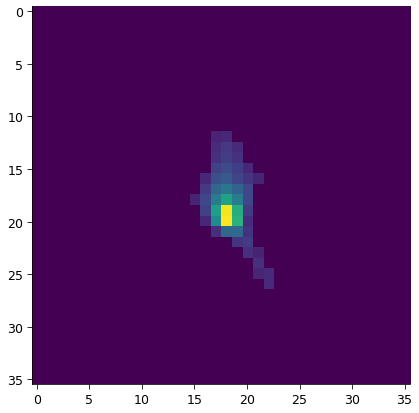

In [363]:
plt.imshow(train_x[300])

In [364]:
# transforms.Compose([
#     transforms.CenterCrop(10),
#     transforms.PILToTensor(),
#     transforms.ConvertImageDtype(torch.float),
# ])


# Transformations to use
from torchvision import transforms
import torch

In [365]:
class RandomResize(object):
    """Randomly resize the image in order to downsample.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

In [378]:
affine = transforms.RandomAffine(180, translate=(0.2, 0.2), scale=(0.7, 1.4), shear=25)
# down_upsample = torch.nn.Sequential(
#     [
# #         ,
#         transforms.Resize(size=image_size),
#     ]
# )

n_views = 2


transformation_list = [affine, transforms.ToTensor()]

trans = transforms.Compose(transformation_list)

view_gen = simclr.ContrastiveLearningViewGenerator(trans, n_views=n_views)















In [395]:
view_gen(train_x[:5])

TypeError: Unexpected type <class 'numpy.ndarray'>

In [379]:
# Flipping
# Gaussian Blur
# 0.7 - 1.4 for scaling
# Translation — -.2, .2
# Rotation -180 to 180
# Shear -25 25
# Sharpening filter
# Piecewise Affine Transform for Warping
# Gaussian / Poisson Noise

In [380]:
# tmp_vis = affine.forward(torch.Tensor(train_x[:10]))
# for img in range(tmp_vis.shape[0]):
#     fig, ax = plt.subplots(1, 3)
#     ax[0].imshow(tmp_vis[img])
#     ax[1].imshow(train_x[img])
#     ax[2].imshow(train_x[img])

In [381]:
# DownSampling / UpSampling
# Ally — collects and that other people collect — neurons end up being around 9 pixels
# Rich's — Data 15x200 pixels -- instead of an edge with of 12, they have 3-4

In [382]:
# Minimum resizing value 33% in each dim (i.e. 1/9 for overall values)
# 

In [383]:
import simclr

# @markdown Import modules designed for use in this tutorials
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util


In [384]:
# 1. Load Data
# 2. Define torch DataSet
# 3. Define data augmentations
# 4. Create datset with augmentations
# 5. Define SimCLR Object
# 6. Train SimCLR Object with augmented DataSet


In [385]:
class Empty():
    def __init__(self):
        pass

In [386]:
from torch.optim import Adam
from torch.optim import lr_scheduler

In [387]:
# https://github.com/sthalles/SimCLR/blob/1848fc934ad844ae630e6c452300433fe99acfd9/simclr.py
model = simclr.Net()

args = Empty()
args.device = 'cpu'
args.fp16_precision = False
args.epochs = 5
args.disable_cuda = True
args.n_views = n_views
args.batch_size=32
args.temperature=1
args.log_every_n_steps=10

optimizer = Adam(model.parameters())
scheduler = lr_scheduler.ExponentialLR(optimizer, 0.01)
sc = simclr.SimCLR(args=args, model=model, optimizer=optimizer, scheduler=scheduler)

In [388]:
dl, ds, smpl = simclr.make_WindowedDataloader(train_x[:,None,:,:], train_y,
                                              batch_size=args.batch_size,
                                              drop_last=True,
                                              transform=view_gen)


In [389]:
sc.train(dl)

  0%|          | 0/518 [00:00<?, ?it/s]


IndexError: The shape of the mask [64, 64] at index 0 does not match the shape of the indexed tensor [32, 32] at index 0

In [390]:
emb = model.get_embedding(torch.tensor(train_x[:,None,:,:])).squeeze()

In [339]:
emb = emb.detach().numpy()

In [340]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embpca = pca.fit_transform(emb)
embpca

array([[ 0.09393109, -0.05296358],
       [ 0.09528087, -0.04828813],
       [-0.06244125, -0.05658171],
       ...,
       [ 0.09188318, -0.05379198],
       [-0.06039738, -0.05432424],
       [-0.06411313, -0.05148393]], dtype=float32)

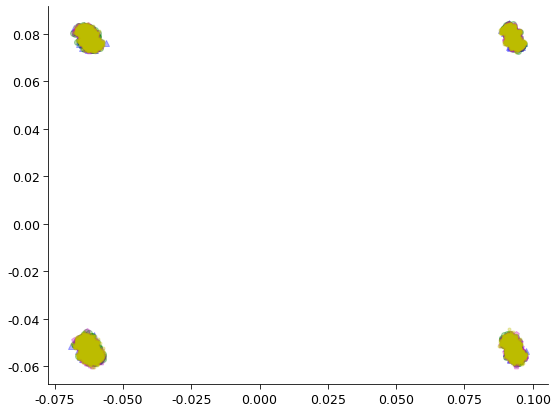

In [341]:
markers = ['^', 'o', 's', 'v', 'p', '.', '.']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for im, marker in enumerate(markers):
    lc = np.where(train_y.astype(int)==im)
    plt.scatter(embpca[lc,0], embpca[lc,1], marker=marker, color=colors[im], alpha=0.3)

In [342]:
sc.writer.close()